<a href="https://colab.research.google.com/github/pedrodeparis/An-liseXadrez/blob/main/Chess_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sempre fui um amante do xadrez e, de alguns anos para cá, com a volta da popularidade do jogo e a possibilidade de jogar online, me reaproximei do jogo. Posso dizer que virou uma rotina, quase que uma maneira de "aquecer" meu cérebro antes de começar o dia.

No xadrez, há uma espécie de ranking dos jogadores, que chamamos rating. O meu objetivo sempre foi subir, pois assim jogaria com jogadores melhores, exploraria posições interessantes. Contudo, eu percebo que eu oscilo demais.

Mas, como tudo na vida, existe uma solulação: usar meus dados para identificar padrões.

Assim, resolvi documentar e compartilhar com vocês as análises que fiz,  bem como os códigos utilizados. Vamos lá!   

De início, baixamos a API do chess.com e aproveitamos observamos a documentação (link: https://chesscom.readthedocs.io/en/latest/).

In [296]:
pip install chess.com

Aqui, para trazermos nossa base de dados, vamos usar a função documentada como get_player_game_archives.

In [297]:
from chessdotcom import get_player_game_archives, Client

Client.request_config["headers"]["User-Agent"] = (
   "My Python Application. "
   "Contact me at email@example.com"
)
jogos = get_player_game_archives("GarnierChess")

In [298]:
import pandas as pd
import numpy as np
import json
import pprint
from pprint import pprint

Agora, analisando o que o pprint nos retorna podemos ver que temos acesso a todos dados das partidas jogadas em novembro.


In [299]:
pprint(jogos)


ChessDotComResponse(json={'archives': ['https://api.chess.com/pub/player/garnierchess/games/2021/08', 'https://api.chess.com/pub/player/garnierchess/games/2021/09', 'https://api.chess.com/pub/player/garnierchess/games/2021/10', 'https://api.chess.com/pub/player/garnierchess/games/2021/11', 'https://api.chess.com/pub/player/garnierchess/games/2021/12', 'https://api.chess.com/pub/player/garnierchess/games/2022/01', 'https://api.chess.com/pub/player/garnierchess/games/2022/02', 'https://api.chess.com/pub/player/garnierchess/games/2022/03', 'https://api.chess.com/pub/player/garnierchess/games/2022/04', 'https://api.chess.com/pub/player/garnierchess/games/2022/05', 'https://api.chess.com/pub/player/garnierchess/games/2022/06', 'https://api.chess.com/pub/player/garnierchess/games/2022/07', 'https://api.chess.com/pub/player/garnierchess/games/2022/08', 'https://api.chess.com/pub/player/garnierchess/games/2022/09', 'https://api.chess.com/pub/player/garnierchess/games/2022/10', 'https://api.che

Agora, bora começar a tratar os dados, criando uma tabela e trazendo os valores retornados para ela. Aqui o grande trabalho vai ser passar o valor retornado para cada uma das colunas. Tive alguns problemas para o URL retornar os dados, mas consegui através do código abaixo.

In [300]:
pip install python-chess

In [301]:
import chess.pgn

Reparem que esse for ficou muito complexo. Isso porque, analisando a estrutura de dados, percebi que o que eu precisava para minha análise estava em duas maneiras: alguns dados estavam dentro da "key" pgn e outros correspondiam as suas próprias keys, o que complicou um pouco.

Contudo, isso foi ótimo para entender melhor as estruturas JSON e como manipular os dados!

In [302]:
import requests
import json
import re

api_url = "https://api.chess.com/pub/player/garnierchess/games/2023/11"
headers = {
    "User-Agent": "My Python Application. Contact me at email@example.com"
}

response = requests.get(api_url, headers=headers)


if response.status_code == 200:
    try:
        data = response.json()
        games = []
        for game in data['games']:
            termination = None
            eco_url = None
            utc_date = None

            if 'pgn' in game:
                termination_match = re.search(r'\[Termination "(.*?)"\]', game['pgn'])
                eco_match = re.search(r'\[ECOUrl "(.*?)"\]', game['pgn'])
                utc_date_match = re.search(r'\[UTCDate "(.*?)"\]', game['pgn'])

                if termination_match:
                    termination = termination_match.group(1)

                if eco_match:
                    eco_url = eco_match.group(1)

                if utc_date_match:
                    utc_date = utc_date_match.group(1)

            games.append({
                "White": game["white"]["username"],
                "Black": game["black"]["username"],
                "Date": game["end_time"],
                "URL": game["url"],
                "Link": eco_url,
                "Termination": termination,
                "TimeControl": game["time_control"],
                "UTCDate": utc_date
            })

    except json.JSONDecodeError:
        print("Erro ao decodificar JSON: A resposta não é um JSON válido.")
else:
    print(f"Erro na solicitação. Status code: {response.status_code}")

In [303]:
 df = pd.DataFrame(games)

In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   White        740 non-null    object
 1   Black        740 non-null    object
 2   Date         740 non-null    int64 
 3   URL          740 non-null    object
 4   Link         740 non-null    object
 5   Termination  740 non-null    object
 6   TimeControl  740 non-null    object
 7   UTCDate      740 non-null    object
dtypes: int64(1), object(7)
memory usage: 46.4+ KB


Podemos ver que há problema com as colunas ECOUrl (que corresponde a abertura da partida) e com a coluna Termination (resultado da partida). Além disso, mudarei a coluna white e black para binárias, respondendo 1 na coluna em que eu joguei. Também vou tratar o Date, dividindo em hora e dia.

In [305]:
df.drop(columns=['Date'])

,White,Black,URL,Link,Termination,TimeControl,UTCDate
0,nexhi34,GarnierChess,https://www.chess.com/game/live/92618498743,https://www.chess.com/openings/Modern-Defense-...,nexhi34 won by resignation,180,2023.11.01
1,GarnierChess,AMAR_KUMAR_28,https://www.chess.com/game/live/92618548193,https://www.chess.com/openings/Vienna-Game-Max...,GarnierChess won by checkmate,180,2023.11.01
2,akampuriraadidasi,GarnierChess,https://www.chess.com/game/live/92619037447,https://www.chess.com/openings/English-Opening...,akampuriraadidasi won by resignation,180,2023.11.01
3,GarnierChess,akampuriraadidasi,https://www.chess.com/game/live/92619096657,https://www.chess.com/openings/Giuoco-Piano-Ga...,akampuriraadidasi won by checkmate,180,2023.11.01
4,akampuriraadidasi,GarnierChess,https://www.chess.com/game/live/92619140771,https://www.chess.com/openings/English-Opening...,GarnierChess won on time,180,2023.11.01
...,...,...,...,...,...,...,...
735,GarnierChess,sanapakrishna,https://www.chess.com/game/live/95110860959,https://www.chess.com/openings/Vienna-Game-Fal...,GarnierChess won by checkmate,180,2023.11.30
736,sanapakrishna,GarnierChess,https://www.chess.com/game/live/95111338517,https://www.chess.com/openings/Modern-Defense-...,GarnierChess won by checkmate,180,2023.11.30
737,GarnierChess,sanapakrishna,https://www.chess.com/game/live/95111401221,https://www.chess.com/openings/Scandinavian-De...,GarnierChess won by checkmate,180,2023.11.30
738,GarnierChess,Sid1354,https://www.chess.com/game/live/95114936945,https://www.chess.com/openings/French-Defense-...,Sid1354 won by checkmate,180,2023.11.30


Agora, próximo passo para facilitar nossa análise é transformar a coluna white e black em binária, simplificar o termination para vitória, derrota ou empate e mudar a coluna "link" para abertura e substituir o url para tão somente o nome da abertura, i.e Modern Defense, Vienna, English, etc...

In [306]:
def categorizar_resultado(valor):
    if 'GarnierChess' in valor:
        return 'Vitória'
    elif 'draw' in valor:
        return 'Empate'
    else:
        return 'Derrota'


df['Termination'] = df['Termination'].apply(categorizar_resultado)

In [307]:
df.head(10)

,White,Black,Date,URL,Link,Termination,TimeControl,UTCDate
0,nexhi34,GarnierChess,1698879790,https://www.chess.com/game/live/92618498743,https://www.chess.com/openings/Modern-Defense-...,Derrota,180,2023.11.01
1,GarnierChess,AMAR_KUMAR_28,1698879911,https://www.chess.com/game/live/92618548193,https://www.chess.com/openings/Vienna-Game-Max...,Vitória,180,2023.11.01
2,akampuriraadidasi,GarnierChess,1698880174,https://www.chess.com/game/live/92619037447,https://www.chess.com/openings/English-Opening...,Derrota,180,2023.11.01
3,GarnierChess,akampuriraadidasi,1698880375,https://www.chess.com/game/live/92619096657,https://www.chess.com/openings/Giuoco-Piano-Ga...,Derrota,180,2023.11.01
4,akampuriraadidasi,GarnierChess,1698880681,https://www.chess.com/game/live/92619140771,https://www.chess.com/openings/English-Opening...,Vitória,180,2023.11.01
5,pedroblazquez,GarnierChess,1698880896,https://www.chess.com/game/live/92619675963,https://www.chess.com/openings/Queens-Pawn-Ope...,Derrota,180,2023.11.01
6,nickaguilera123,GarnierChess,1698881177,https://www.chess.com/game/live/92619722205,https://www.chess.com/openings/Vienna-Game-Max...,Vitória,180,2023.11.01
7,GarnierChess,vaderslightsaber,1698881460,https://www.chess.com/game/live/92620250245,https://www.chess.com/openings/Queens-Pawn-Ope...,Derrota,180,2023.11.01
8,GarnierChess,Ceegix,1698881787,https://www.chess.com/game/live/92620311747,https://www.chess.com/openings/Modern-Defense-...,Derrota,180,2023.11.01
9,GarnierChess,sperss10990,1698882118,https://www.chess.com/game/live/92620859079,https://www.chess.com/openings/Queens-Pawn-Ope...,Derrota,180,2023.11.01


In [308]:
df['Cor_das_Pecas'] = df.apply(lambda row: 'Brancas' if 'GarnierChess' in row['White'] else 'Pretas' if 'GarnierChess' in row['Black'] else None, axis=1)

In [309]:
df['Modalidade'] = df.apply(lambda row: 'blitz' if '180' in row['TimeControl'] else None, axis=1)

In [310]:
df.head()

,White,Black,Date,URL,Link,Termination,TimeControl,UTCDate,Cor_das_Pecas,Modalidade
0,nexhi34,GarnierChess,1698879790,https://www.chess.com/game/live/92618498743,https://www.chess.com/openings/Modern-Defense-...,Derrota,180,2023.11.01,Pretas,blitz
1,GarnierChess,AMAR_KUMAR_28,1698879911,https://www.chess.com/game/live/92618548193,https://www.chess.com/openings/Vienna-Game-Max...,Vitória,180,2023.11.01,Brancas,blitz
2,akampuriraadidasi,GarnierChess,1698880174,https://www.chess.com/game/live/92619037447,https://www.chess.com/openings/English-Opening...,Derrota,180,2023.11.01,Pretas,blitz
3,GarnierChess,akampuriraadidasi,1698880375,https://www.chess.com/game/live/92619096657,https://www.chess.com/openings/Giuoco-Piano-Ga...,Derrota,180,2023.11.01,Brancas,blitz
4,akampuriraadidasi,GarnierChess,1698880681,https://www.chess.com/game/live/92619140771,https://www.chess.com/openings/English-Opening...,Vitória,180,2023.11.01,Pretas,blitz


In [311]:
df['Link'].unique()

array(['https://www.chess.com/openings/Modern-Defense-with-1-d4',
       'https://www.chess.com/openings/Vienna-Game-Max-Lange-Defense-3.Bc4-Nf6',
       'https://www.chess.com/openings/English-Opening-Great-Snake-Variation-2.Nc3-Bg7-3.e4-d6',
       'https://www.chess.com/openings/Giuoco-Piano-Game-Giuoco-Pianissimo-Variation-4...Nf6',
       'https://www.chess.com/openings/English-Opening-Caro-Kann-Defensive-System-2.Nc3-d5-3.cxd5-cxd5-4.d4',
       'https://www.chess.com/openings/Queens-Pawn-Opening-Mikenas-Defense',
       'https://www.chess.com/openings/Vienna-Game-Max-Lange-Defense',
       'https://www.chess.com/openings/Queens-Pawn-Opening-Zukertort-Variation',
       'https://www.chess.com/openings/Modern-Defense-with-1-e4-2.Nc3',
       'https://www.chess.com/openings/Sicilian-Defense-Old-Sicilian-Variation-3.Bc4-e6',
       'https://www.chess.com/openings/Queens-Pawn-Opening-Zukertort-Chigorin-Variation',
       'https://www.chess.com/openings/Nimzowitsch-Defense-Kennedy-Var

In [312]:
df['Abertura'] = df['Link'].apply(lambda x: re.search(r'/openings/([^/]+)', x).group(1))
df['Abertura'] = df['Abertura'].str.replace(r'-\d.*$', '', regex=True)

In [313]:
df['Abertura'].nunique()

148

In [314]:
jogos_df = df.drop(columns= ['White', 'Black', 'Date', 'TimeControl', 'Link'])

In [315]:
jogos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   URL            740 non-null    object
 1   Termination    740 non-null    object
 2   UTCDate        740 non-null    object
 3   Cor_das_Pecas  740 non-null    object
 4   Modalidade     717 non-null    object
 5   Abertura       740 non-null    object
dtypes: object(6)
memory usage: 34.8+ KB


Aqui percebi que 717 jogos que joguei são blitz. Como essa é a única modalidade que me interessa e a que eu mais gosto de jogar, para fim da minha análise, vou excluir os jogos que não foram nesse formato.

In [316]:
jogos_df = jogos_df[jogos_df['Modalidade'] == 'blitz']

In [317]:
jogos_df['Abertura'].unique()

array(['Modern-Defense-with', 'Vienna-Game-Max-Lange-Defense',
       'English-Opening-Great-Snake-Variation',
       'Giuoco-Piano-Game-Giuoco-Pianissimo-Variation',
       'English-Opening-Caro-Kann-Defensive-System',
       'Queens-Pawn-Opening-Mikenas-Defense',
       'Queens-Pawn-Opening-Zukertort-Variation',
       'Sicilian-Defense-Old-Sicilian-Variation',
       'Queens-Pawn-Opening-Zukertort-Chigorin-Variation',
       'Nimzowitsch-Defense-Kennedy-Variation',
       'Sicilian-Defense-Hyperaccelerated-Dragon-Variation',
       'Nimzowitsch-Defense', 'Kings-Pawn-Opening-Kings-Knight-Variation',
       'Indian-Game-Knights-Variation',
       'Closed-Sicilian-Defense-Traditional-Line', 'Mieses-Opening',
       'Caro-Kann-Defense',
       'Nimzowitsch-Defense-Kennedy-Linksspringer-Variation',
       'Caro-Kann-Defense-Exchange-Variation', 'Closed-Sicilian-Defense',
       'Four-Knights-Game',
       'Englund-Gambit-Declined-Reversed-Alekhine-Variation',
       'Caro-Kann-Defense-Br

Aqui eu ainda quero agrupar mais as aberturas, pois quero fazer analises onde não importa a variável da abertura. Por ex, Siciliana possui a "fechada", "Accelerate Dragon" e etc. Eu quero vê-la apenas como Siciiana. Assim, defini uma função para localiar as palavras chaves e criar uma nova tabela agrupando.

In [318]:
def agrupar_aberturas(abertura):
    if 'Modern' in abertura:
        return 'Modern Defense'
    elif 'Vienna' in abertura:
        return 'Vienna Game'
    elif 'English' in abertura:
        return 'English Opening'
    elif 'Giuoco-Piano' in abertura:
        return 'Giuoco Piano'
    elif 'Caro-Kann' in abertura:
        return 'Caro-Kann Defense'
    elif 'Queens-Pawn' in abertura:
        return 'Queens Pawn Opening'
    elif 'Sicilian' in abertura:
        return 'Sicilian Defense'
    elif 'Nimzowitsch' in abertura:
        return 'Nimzowitsch Defense'
    elif 'Kings' in abertura:
        return 'Kings Pawn Opening'
    elif 'Indian' in abertura:
        return 'Indian Game'
    elif 'Closed-Sicilian' in abertura:
        return 'Closed Sicilian Defense'
    else:
        return abertura

jogos_df['Abertura_Agrupada'] = jogos_df['Abertura'].apply(agrupar_aberturas)


In [319]:
import matplotlib.pyplot as plt
import seaborn as sns

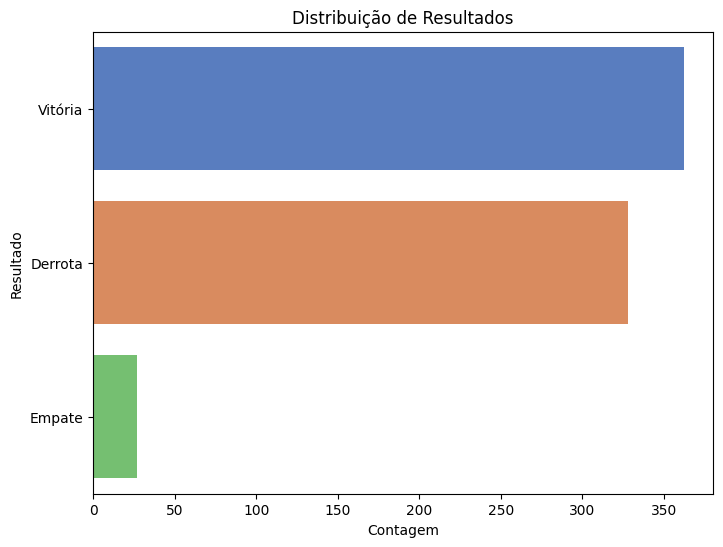

In [320]:
termination_count = jogos_df['Termination'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(y=termination_count.index, x=termination_count.values, palette='muted')
plt.title('Distribuição de Resultados')
plt.xlabel('Contagem')
plt.ylabel('Resultado')
plt.show()


In [321]:
jogos_df['Vitoria'] = jogos_df['Termination'].apply(lambda x: 1 if x == 'Vitória' else 0)
estatisticas_aberturas = jogos_df.groupby('Abertura_Agrupada').agg({'Vitoria': ['count', 'sum']})
estatisticas_aberturas.columns = ['Total_Partidas', 'Vitorias']
estatisticas_aberturas['Taxa_Vitoria'] = estatisticas_aberturas['Vitorias'] / estatisticas_aberturas['Total_Partidas'] * 100
estatisticas_aberturas = estatisticas_aberturas.sort_values(by='Total_Partidas', ascending=False)

print(estatisticas_aberturas)

                                                    Total_Partidas  Vitorias  \
Abertura_Agrupada                                                              
Modern Defense                                                 153        73   
Sicilian Defense                                               101        53   
Vienna Game                                                     98        54   
Caro-Kann Defense                                               53        20   
Kings Pawn Opening                                              37        17   
Queens Pawn Opening                                             36        18   
Nimzowitsch Defense                                             27        15   
French-Defense-Queens-Knight-Variation                          25        11   
Scandinavian-Defense-Closed                                     17         9   
Scandinavian-Defense-Mieses-Kotrc-Variation                     16        10   
Scandinavian-Defense-Mieses-Kotrc-Main-L

Como existem aberturas que eu joguei só uma vez e são muito específicas, resolvi filtrar pelo top 10 mais jogadas.

In [322]:
top_10_aberturas = estatisticas_aberturas.head(10)

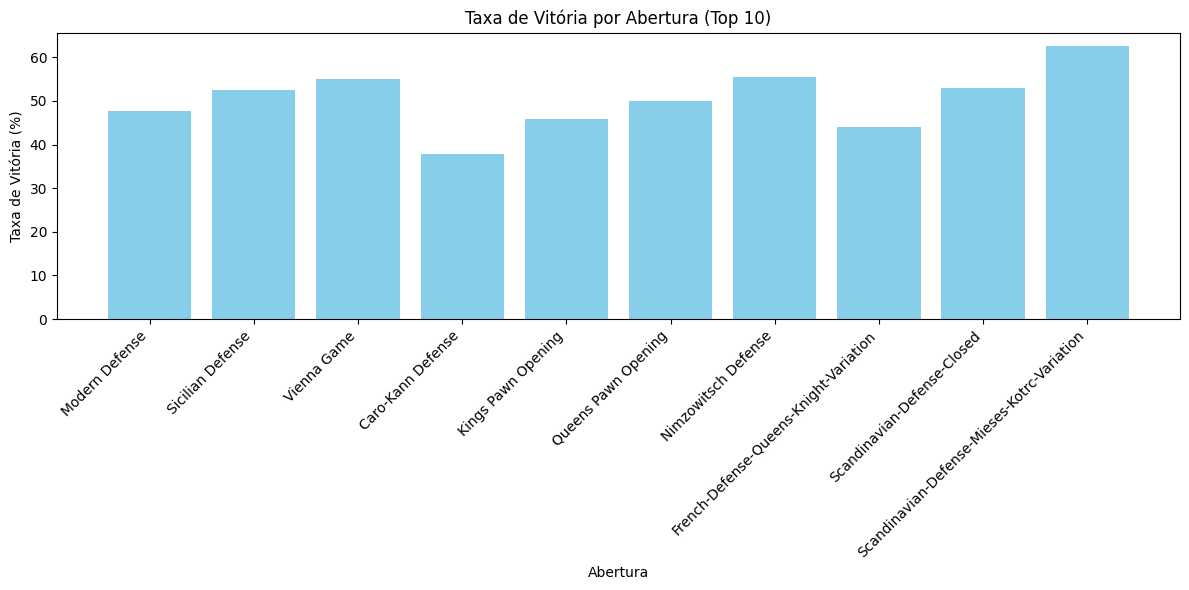

In [323]:
plt.figure(figsize=(12, 6))
plt.bar(top_10_aberturas.index, top_10_aberturas['Taxa_Vitoria'], color='skyblue')
plt.title('Taxa de Vitória por Abertura (Top 10)')
plt.xlabel('Abertura')
plt.ylabel('Taxa de Vitória (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

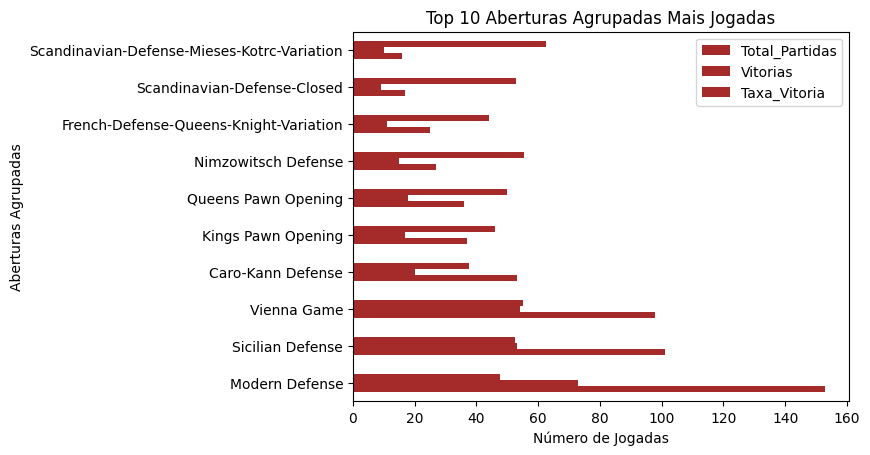

In [330]:
plt.figure(figsize=(10, 6))
top_10_aberturas.plot(kind='barh', color='brown')
plt.title('Top 10 Aberturas Agrupadas Mais Jogadas')
plt.xlabel('Número de Jogadas')
plt.ylabel('Aberturas Agrupadas')
plt.show()

In [325]:
estatisticas_data = jogos_df.groupby('UTCDate').agg({'Vitoria': 'sum'})
estatisticas_data = estatisticas_data.sort_values(by='Vitoria', ascending=False)

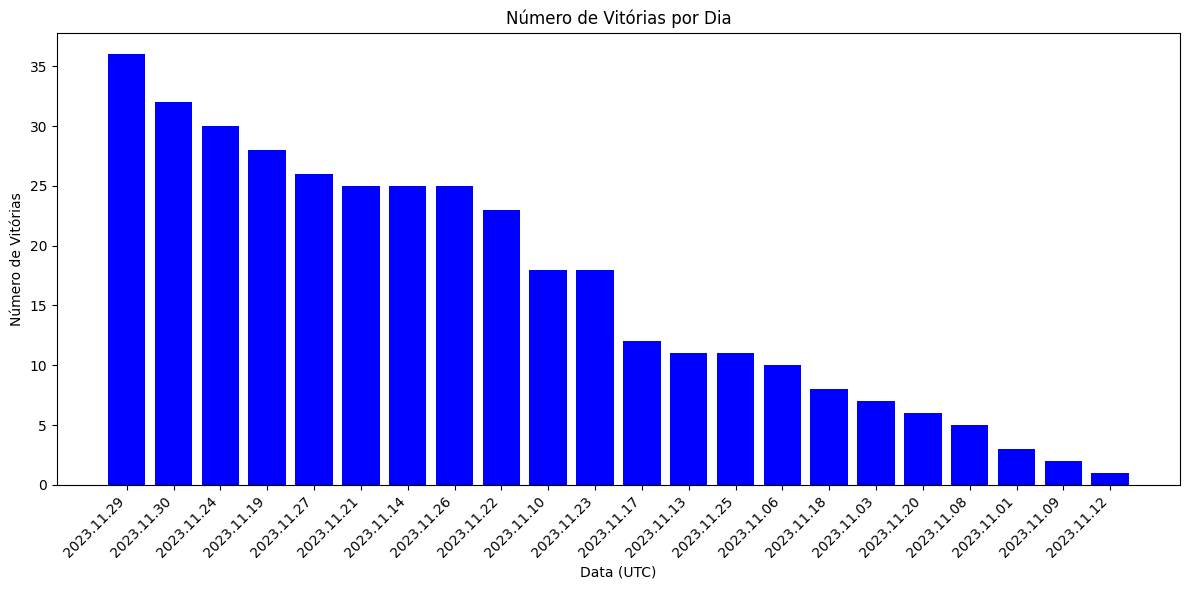

In [326]:
plt.figure(figsize=(12, 6))
plt.bar(estatisticas_data.index, estatisticas_data['Vitoria'], color='blue')
plt.title('Número de Vitórias por Dia')
plt.xlabel('Data (UTC)')
plt.ylabel('Número de Vitórias')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [327]:
empates_por_abertura = jogos_df[jogos_df['Termination'] == 'Empate'].groupby('Abertura_Agrupada').size()
empates_por_abertura = empates_por_abertura.sort_values(ascending=False)

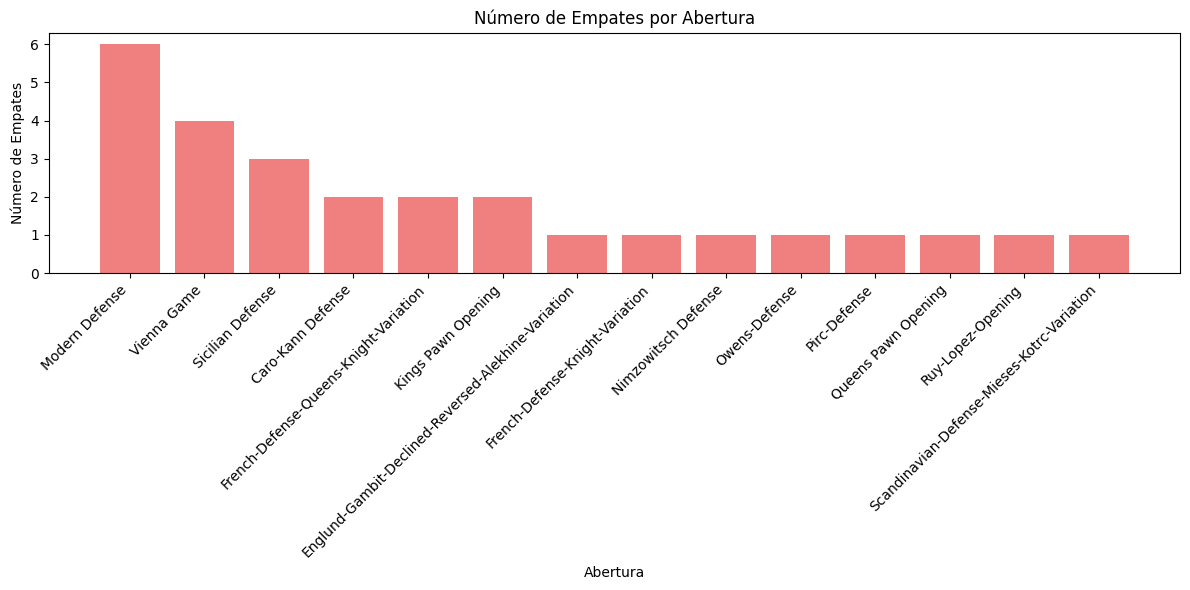

In [328]:
plt.figure(figsize=(12, 6))
plt.bar(empates_por_abertura.index, empates_por_abertura, color='lightcoral')
plt.title('Número de Empates por Abertura')
plt.xlabel('Abertura')
plt.ylabel('Número de Empates')
plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos do eixo x para melhor legibilidade
plt.tight_layout()
plt.show()

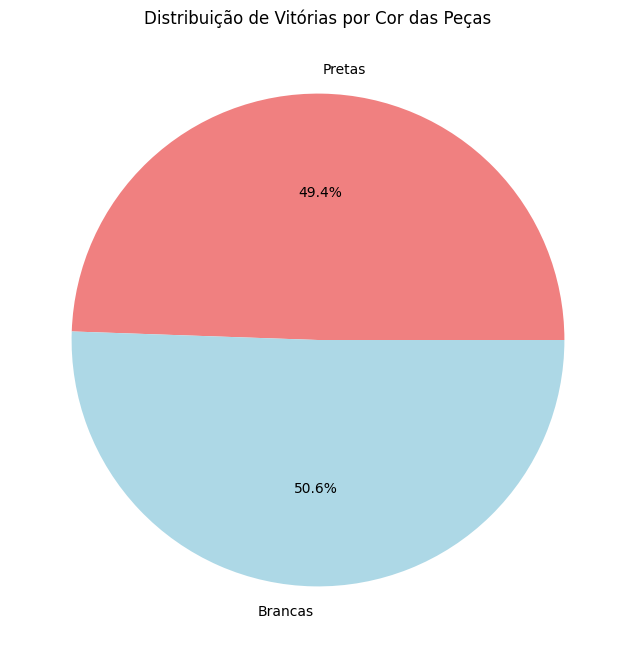

In [329]:
plt.figure(figsize=(8, 8))
colors = ['lightcoral', 'lightblue']
plt.pie(jogos_df.groupby('Cor_das_Pecas')['Vitoria'].sum(), labels=df['Cor_das_Pecas'].unique(), autopct='%1.1f%%', colors=colors)
plt.title('Distribuição de Vitórias por Cor das Peças')
plt.show()
